<a href="https://colab.research.google.com/github/taimur1871/car_sales_prediction/blob/main/Car_sales_predictions_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Today you are a Data Scientist at Tesla! 
## You have assigned a new project to look at car sales from Quarters 1-2 in California for 2019 to make predictions as to which cars will be sold more than the others in Q3 and Q4, to ensure enough inventory to meet demands!

### If running this notebook in Google Colab, run the following cells first. Make sure you've placed the Q12 and Q34 sales data in the same Google Drive folder as this notebook.

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Replace the ID with ID of file you want to access. To get this ID: 

1.   Right-click on the name of the appropriate file in your Google Drive
2.   Click "Get link"
3.   Copy the characters between `d/` and the following slash
4.   Paste them into the dictionary argument of the call to `drive.CreateFile()` as the value associated with the 'id' key. Make sure that this value is a string.



In [ ]:
# Replace the ID with ID of file you want to access
Q12 = drive.CreateFile({'id':'1vpppIqAvvH8O44XEUEYlEk96clxbQEG7'}) 
Q12.GetContentFile('sales_Q12_2019.csv') 
Q34 = drive.CreateFile({'id':'1He76yUv5030l_qhugdhSOf3OjUEbrElI'}) 
Q34.GetContentFile('sales_Q34_2019.csv') 

### Import the necessary modules

In [3]:
import os
import tensorflow as tf
from tensorboard.plugins import projector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

### Read in the CSV file containing the California sales data for Quarters 1 and 2

Then examine the data's shape and first few rows

In [5]:
df_sales = pd.read_csv("Sales_Q12_2019.csv")
print(df_sales.shape)
df_sales.head()

(5837, 76)


,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP,dealer_state,date
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44610,California,2019-04-28
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41505,California,2019-03-14
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58890,California,2019-06-12
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51055,California,2019-03-04
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70830,California,2019-01-23


### Begin cleaning the data

Eliminate the `'dealer_state'` and `'date'` columns. The former is useless to our model, since we already know that our dataset is restricted to California sales. While we could possibly extract useful information from the `'date'` column (for example, to determine whether more cars are sold on weekends than weekdays), we'll be focusing on car configurations in this exercise.

In [6]:
df_sales = df_sales.drop(columns=['dealer_state','date'])
df_sales.head()

,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44610
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41505
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58890
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51055
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70830


### Read in the CSV file containing the California sales data for Quarters 3 and 4

The `'dealer_state'` and `'date'` columns have already been eliminated in this dataset, so you don't need to worry about them here. Examine the data's shape and first few rows.

In [8]:
### START CODE HERE ###
# Read in the Q34 data
df_pred = pd.read_csv('sales_Q34_2019.csv')
# Print the shape of the data
print(df_pred.shape)
# Examine the first few rows of the data
df_pred.head()
### END CODE HERE ###

(6666, 74)


,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,51355
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,71580
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,66790
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72330
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55370


# Task I. Consolidate data by finding numbers of unique car combinations sold for training and test data sets

You've probably noticed that 73 of the 74 columns in our Q12 and Q34 datasets are one-hot-encoded representations of the car's `'main_type'`, `'engine'`, and `'sales_version'` values. You've probably also noticed that the final column is the car's `'MSRP'`, or manufacturer's (Tesla's, in this case) suggested retail price. In its current form, the sales data doesn't contain a target. The car's `'main_type'`, `'engine'`, `'sales_version'`, and `'MSRP'` values are all known to us before the time of the sale and do not, by themselves, offer us anything which we can predict. 

However, each row represents the sale of a single car. If we define a unique car type by its combination of `'main_type'`, `'engine'`, and `'sales_version'` values, the number of rows displaying that combination corresponds to the number of times during that half of the year that that distinct type of car was sold in California. Therefore, we can make training and test datasets where each row now corresponds to a unique car type, and the target value is how many times that car type was sold in California during a given half of the year.

## This task requires data wrangling!
## Create functions that read the Q12 (df_sales) and Q34 (df_pred) data sets and create train_X, train_Y, test_X and test_Y, respectively. Use pandas and NumPy as needed.

train_X, test_X = unique row combinations without MSRP column

train_Y, test_Y = number of unique cars sold

In [39]:
def get_features_and_targets(df):
    ### START CODE HERE ###
    # Create the local data DataFrame as a copy of the input df DataFrame, minus the 'MSRP' column
    data = df.copy()
    data.drop('MSRP', axis=1, inplace=True)
    data_y = data.value_counts(normalize=True, sort=False)
    # Use the value_counts() method for DataFrames to store the targets as a NumPy array of the 
    # normalized sales counts associated with each unique combination of 'main_type', 'engine', 
    # and 'sales_version' values in the data DataFrame
    # Make sure the counts are unsorted, so they're listed in order of the combination's first appearance
    # in the data DataFrame, and that the array is 2D, with 1 entry per row
    Y = data_y.to_numpy()
    Y = Y.reshape(Y.shape[0], 1)
    # Get a list of the column names of the data DataFrame
    subset_names = data.columns.values.tolist()
    # Use the drop_duplicates() method on the df DataFrame to store the features data as a NumPy array where
    # each row corresponds to a unique combination of 'main_type', 'engine', and 'sales_version' values
    # Make sure to set the subset parameter to subset_names, so the 'MSRP' column isn't included in the 
    # uniqueness calculations
    X = np.array(df.drop_duplicates(subset=subset_names))
    # Scale and shift the 'MSRP' column so its values fall in the range [0,1]
    # You might find NumPy's ptp() function useful
    X[:,-1] = ( X[:,-1] - min(X[:,-1]) ) / np.ptp(X[:,-1])
    # Return features and targets
    return X, Y
    ### END CODE HERE ###

### Extract features and targets as defined above from both the Q12 and Q34 datasets

In [42]:
### START CODE HERE ###
# Extract training features and targets from the Q12 data
train_X, train_Y = get_features_and_targets(df_sales)
# Extract test features and targets from the Q34 data
test_X, test_Y = get_features_and_targets(df_pred)
### END CODE HERE ###
print(f"Number of unique cars in Q12 = {len(train_Y)}")
print(f"Number of unique cars in Q34 = {len(test_Y)}")

Number of unique cars in Q12 = 66
Number of unique cars in Q34 = 71


You probably noticed that the Q12 and Q34 datasets contained differing numbers of distinct cars. Clearly, some new models were introduced by Q3, but were any discontinued by the end of Q2? Let's find out.

In [43]:
# How many unique cars in 2012 (Q1:Q4)?
### START CODE HERE ### 
# Concatenate the Q12 and Q34 DataFrames into a single DataFrame
df_full = pd.concat([df_sales, df_pred])
# Extract features and targets from the concatenated Q14 data
data_X, data_Y = get_features_and_targets(df_full)
### END CODE HERE ###
print(f"Number of unique cars in Q12 and Q34 = {len(data_Y)}")

Number of unique cars in Q12 and Q34 = 80


The following probability equations are true for any two events $A$ and $B$:`

$$P (A \cup B) = P(A) + P(B) - P (A \cap B)$$
$$P(A) = P (A \cap B) + P (A \cap B^c)$$

Use them to determine how many car models were sold in both halves of 2019, how many were discontinued by the second half of the year, and how many were launched in the second half of the year.

In [53]:
### START CODE HERE ###
pA = len(train_Y) # using as proxy for P(A)
pB = len(test_Y) # using as proxy for P(B)
pAB = len(data_Y) # using as proxy for P(A U B)

print('cars common in both halves: ', pA + pB -pAB )# using A intersection B

# so cars discontinued in h1 is 
print('cars discontinued from h1: ', pA-(pA + pB -pAB))

# new models introduced in h2 is
print('new cars introduced in h2: ', pB-(pA + pB -pAB))

### END CODE HERE ###

cars common in both halves:  57
cars discontinued from h1:  9
new cars introduced in h2:  14


# Task II: Visualize the training and test targets any way you see fit

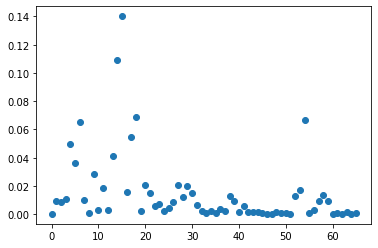

In [80]:
# Visualize the training targets
### START CODE HERE ###
plt.scatter(range(len(train_Y)), train_Y)
plt.show()
### END CODE HERE ###

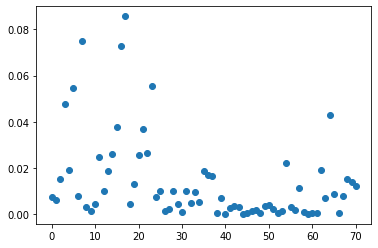

In [81]:
# Visualize the test targets
### START CODE HERE ###
plt.scatter(range(len(test_Y)), test_Y)
plt.show()
### END CODE HERE ###

# Task III: Apply Gradient Descent (Linear, Polynomial)

Initialize the $\theta$ parameters as a column vector of zeros, one for every feature in the training data plus one for bias. 

Also set hyperparameters for learning rate and maximum number of iterations through the training data.

In [82]:
# Initialize learned parameters theta and hyperparameters
s_theta = np.zeros((train_X.shape[1]+1, 1))
s_learning_rate = 0.001
s_max_iteration = 1000

### Hypothesis Function

Define your hypothesis function $h$ (which you use to make predictions $\hat{Y}$ as the matrix product of your features data X and parameters theta, in that order. 

Don't forget to add a 0th column of ones to X to account for the bias/offset parameter.

In [83]:
# Define your hypothesis function according to the instructions above
def h (theta, X) :
    ### START CODE HERE ###
    tempX = np.append(np.ones((X.shape[0], 1)), X, axis=1)
    return np.matmul(tempX, theta)
    ### END CODE HERE ###

Define your loss function as **half** the MSE (mean squared error) between your actual and predicted Y values. 

Recall that the predicted Y values are a function of theta and X.


In [84]:
# Loss Function
def loss (theta, X, Y) :
    ### START CODE HERE ###
    return np.average(np.square(Y-h(theta, X)))/2
    ### END CODE HERE ###

### Gradient of Hypothesis Function

One can verify through straightforward (if somewhat tedious) multivariable calculus that the gradient of the loss function $J$ with respect to the parameters $\theta$ is 

$$ \frac{\partial J}{\partial \theta} = - \frac{1}{m} X^T \cdot (Y - \hat{Y})$$.

Here, $X$ has been augmented with a bias column. 

Set up a function to compute this gradient.

In [85]:
def gradient (theta, X, Y) :
    ### START CODE HERE ###
    # Create a temporary X array with an added 0th bias column
    tempX = np.ones((X.shape[0], X.shape[1] + 1))
    tempX[:,1:] = X
    # Compute the gradient according to the instructions above
    d_theta = - np.average((Y - h(theta, X)) * tempX, axis= 0)
    d_theta = d_theta.reshape(tempX.shape[1], 1)
    ### END CODE HERE ###
    return d_theta

### Gradient Descent

Set up a function to train your linear regression model with gradient descent, i.e. calculate $\frac{\partial J}{\partial \theta}$ and update $\theta$. Recall that the general gradient descent update formula is $\theta := \theta - \alpha \frac{\partial J}{\partial \theta}$. We've provided the skeleton of a stochastic gradient descent function, but you're welcome to experiment with batch and/or minibatch gradient descent. Also recall that the aforementioned gradient descent methods differ in how frequently they calculate $\frac{\partial J}{\partial \theta}$ and update $\theta$. 

In [87]:
def stochastic_gradient_descent (theta, X, Y, learning_rate, max_iteration, gap) :
    ### START CODE HERE ###
    # Initialize the cost as an array of zeros, one for each iteration through the dataset
    cost = np.zeros(max_iteration)
    # Loop over the dataset
    for i in range(max_iteration):
        # Loop over each row in the dataset
        for j in range(X.shape[0]):
            # Compute the gradient from the current row in X and the associated Y value
            # Make sure that both X and Y are represented as 2D row vectors
            d_theta = gradient(theta, X[j].reshape(1, X.shape[1]), Y[j].reshape(1, Y.shape[1]))
            # Update theta
            theta = theta - learning_rate * d_theta
        # Update the cost array for the current iteration
        cost[i] = loss(theta, X, Y)
    ### END CODE HERE ###
        if i % gap == 0 :
            print ('iteration : ', i, ' loss : ', loss(theta, X, Y)) 
    return theta, cost

In [96]:
s_theta, s_cost = stochastic_gradient_descent(s_theta, train_X, train_Y, s_learning_rate, s_max_iteration, 100)

iteration :  0  loss :  0.00017657353425701346
iteration :  100  loss :  0.0001762813696574168
iteration :  200  loss :  0.0001760138733562465
iteration :  300  loss :  0.00017576811255549113
iteration :  400  loss :  0.00017554160802577072
iteration :  500  loss :  0.00017533224628306422
iteration :  600  loss :  0.00017513821269207215
iteration :  700  loss :  0.0001749579396161857
iteration :  800  loss :  0.00017479006557248405
iteration :  900  loss :  0.0001746334025772293


### Generate Predictions from Test Data

In [97]:
### START CODE HERE ###
GD_P = h(s_theta, test_X)
### END CODE HERE ###
# Set any negative predictions to 0
GD_P[GD_P<0] = 0

### Visualize the predicted and actual test labels

RMSE, R2 using SGD= 0.000550679486454796 0.8010722615654465


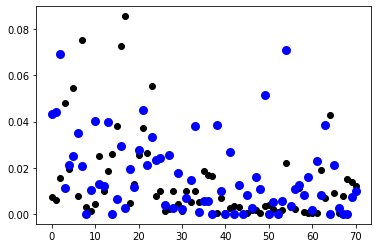

In [98]:
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(GD_P)), GD_P, color='blue', linewidth=3)
from sklearn.metrics import mean_squared_error as MSE

# This function evaluates the R**2 statistic
def r2(Yt,Yp):
    yhat = Yp                         
    ybar = np.sum(Yt)/len(Yt)          
    ssreg = np.sum((yhat-ybar)**2)   
    sstot = np.sum((Yt - ybar)**2)    
    results = ssreg / sstot
    return results


print("RMSE, R2 using SGD=", MSE(test_Y,GD_P), r2(test_Y,GD_P))

# Task IV: Normal Equations

Since our training dataset isn't very large, let's generate predictions using the normal equations: 

$$W = (X^T \cdot X)^{-1} \cdot X^T \cdot Y$$ 
$$\hat{Y} = W^T \cdot X$$

and see how they compare to the predictions which we obtained from gradient descent.

In [198]:
### START CODE HERE ###
# Compute the inverse of the matrix product of the transpose of X and X
# adding a column of zeros for bias
tempX_train = np.append(np.ones((train_X.shape[0], 1)), train_X, axis=1)
tempX_test = np.append(np.ones((test_X.shape[0], 1)), test_X, axis=1)
inv1 = np.linalg.pinv(np.matmul(tempX_train.T, tempX_train))
# Compute W using the first of the Normal Equations
W1 = np.matmul(inv1, np.matmul(tempX_train.T, train_Y))
# Compute the predicted Y values using the second of the Normal Equations
PN1 = np.matmul(W1.T, tempX_test.T)
### END CODE HERE ###

# Set any negative predictions to 0
PN1[np.where(PN1<0)]=0

RMSE, R2 for prediction all features = 0.0005752830089194816 0.8729135062643177


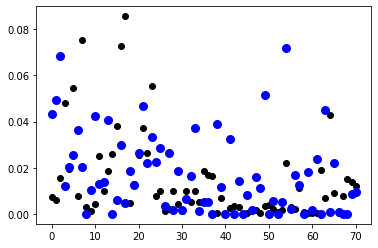

In [199]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(PN1.T)), PN1, color='blue', linewidth=3)
print("RMSE, R2 for prediction all features =", MSE(test_Y,PN1.T), r2(test_Y,PN1.T)) #[Low error high corr]

### Regularized Normal Equations

In [141]:
print('Recall that our training features array train_X has')
print(f'm = {train_X.shape[0]} rows and n = {train_X.shape[1]} columns')

Recall that our training features array train_X has
m = 66 rows and n = 74 columns


`train_X` is thus wider than it is tall, which suggests that the regularized normal equations might perform better in generating label predictions. In this case, we modify the first of the normal equations given above to 

$$W = (X^T \cdot X + \lambda m I)^{-1} \cdot X^T \cdot Y$$.

Here, $\lambda$ is the regularization parameter and $m$ is the number of rows in $X$.

### Repeat the previous parts of Task IV, but this time incorporate regularization

In [204]:
lmbd = [x/10 for x in range(1, 9)]
lmbd

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

In [205]:
### START CODE HERE ###
for i in lmbd:
  inv1 = np.linalg.pinv(np.matmul(train_X.T, train_X)+i*train_X.shape[0]*np.identity(74))

  W1 = np.matmul(inv1, np.matmul(train_X.T, train_Y))

  PN1_reg = np.matmul(W1.T, test_X.T)

  PN1_reg[np.where(PN1<0)]=0
  print("RMSE, R2 for prediction all features =", MSE(test_Y,PN1_reg.T), r2(test_Y,PN1.T))
### END CODE HERE ###

RMSE, R2 for prediction all features = 0.00039689088391802087 0.8729135062643177
RMSE, R2 for prediction all features = 0.000387987351974357 0.8729135062643177
RMSE, R2 for prediction all features = 0.00038986691353293495 0.8729135062643177
RMSE, R2 for prediction all features = 0.0003951503485455689 0.8729135062643177
RMSE, R2 for prediction all features = 0.00040159208506965216 0.8729135062643177
RMSE, R2 for prediction all features = 0.00040828187284113626 0.8729135062643177
RMSE, R2 for prediction all features = 0.00041482024495992093 0.8729135062643177
RMSE, R2 for prediction all features = 0.00042103381488983667 0.8729135062643177


# Task V: Non-linear Regression Models (GLM, DT) 

### Generalized Linear Models

`sm` (our alias for `statsmodels.api`) contains a `GLM` class. Use it to instantiate a model. The relevant parameters are training labels, training features, and `ffamily`, i.e. the family of distributions to which we assume our prediction errors belong. Some potentially good choices for `ffamily` include Gaussian, Gamma, and Logit.

In [212]:
# GLM 
import statsmodels.api as sm
### START CODE HERE ###
# Instantiate the GLM
train_X_glm = sm.add_constant(train_X)

glm_gamma = sm.GLM(train_Y, train_X_glm, family=sm.families.Gaussian())
# Train the GLM
glm_results = glm_gamma.fit()
### END CODE HERE ###
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   66
Model:                            GLM   Df Residuals:                       34
Model Family:                Gaussian   Df Model:                           31
Link Function:               identity   Scale:                      0.00066624
Method:                          IRLS   Log-Likelihood:                 169.60
Date:                Sun, 25 Oct 2020   Deviance:                     0.022652
Time:                        00:26:21   Pearson chi2:                   0.0227
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0209      0.010      2.125      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



### Generate predictions from the test data

In [213]:
### START CODE HERE ###
test_X_glm = sm.add_constant(test_X)
G_P = glm_results.predict(test_X_glm)
### END CODE HERE ###
# Set any negative predictions to 0
G_P[G_P<0]=0

RMSE, R2 for GLM= 0.0005752830089194823 0.8729135062643185


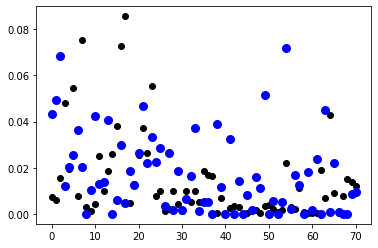

In [214]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(G_P)), G_P, color='blue', linewidth=3)
print("RMSE, R2 for GLM=", MSE(test_Y,G_P), r2(test_Y,G_P)) 

### Random Forest Regression

Use the `RandomForestRegressor` from `sklearn.ensemble` to generate predictions. The relevant parameters are the `max_depth` of the trees and the `random_state`, to ensure reproducibility.

In [164]:
### START CODE HERE ###
from sklearn.ensemble import RandomForestRegressor
# Instantiate the random forest regression model
regr = RandomForestRegressor(max_depth=5, random_state=0)
# Train the model
regr.fit(train_X, np.ravel(train_Y))
# Generate predictions from the test data
pred_rf = regr.predict(test_X)
### END CODE HERE ###

In [165]:
# Set any negative predictions to 0
pred_rf[np.where(pred_rf<0)]=0

RMSE, R2 for Decision Trees= 0.0005928273619876742 0.7776326032928653


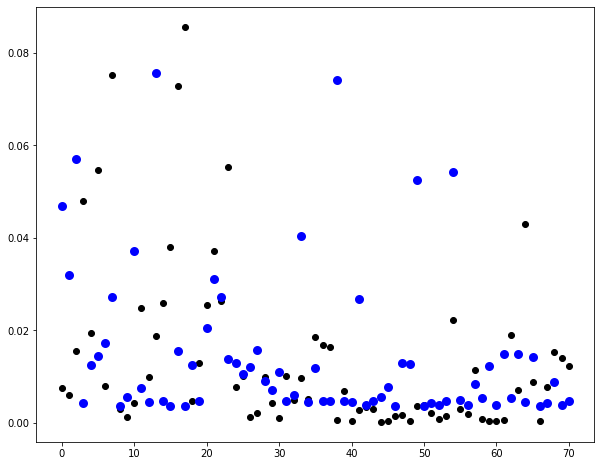

In [281]:
# Plot outputs
plt.figure(figsize=(10,8))
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(pred_rf)), pred_rf, color='blue', linewidth=3)
print("RMSE, R2 for Decision Trees=", MSE(test_Y,pred_rf), r2(test_Y,pred_rf)) #[Low error high corr]

## Populate the table below with the results of your experiments above. Which models performed best?

## Results
---------------------------------------------------------------------------
Method                                          |  RMSE             | R2               |
-------------------------------------------------------------------------------------
1. Gradient Descent RMSE = 0.0005506, R2 = 0.80107
2. Normal Equations RMSE = 0.0005752, R2 = 0.87291
3. Regularized Normal Equations RMSE = 0.0005752, R2 = 0.87291
4. GLM RMSE = 0.0005752, R2 = 0.87291
5. Decision Trees RMSE = 0.0005928, R2 = 0.77763


Based on the above data I would say that gradient descent is the way to go for htis case.The reason is that it is computationally efficient. It was easy to implement. The decision tree might be another option but I did not go very deep with it and so I am not favoring it at the moment.

## Finally, pick some car types for which your models over- and under-predicted sales. Attempt to determine the root causes. Write your findings below.

In [259]:
# creating dict to rename the columns in the dataframe
rename_dict = {}
for i in range(len(list(df_pred.columns))):
  rename_dict[i]=list(df_pred.columns)[i]

In [271]:
# creating data frame from sales and prediction values and sorting
# according to difference between sales and pred
test = pd.DataFrame(test_X)
test[['sales', 'pred', 'diff']] = test_Y, GD_P, test_Y-GD_P
test.rename(rename_dict, axis=1, inplace=True)
test.sort_values(by=['diff'], inplace=True)
top_pred = test.head(1)
top_sales = test.tail(1)

In [276]:
# removing columns with 0 values
top_pred = top_pred.loc[:, (top_pred != 0).any(axis=0)]
top_sales = top_sales.loc[:, (top_sales != 0).any(axis=0)]

In [280]:
# finding highest mismatch
print('top selling car with lowest prediction\n', top_sales)
print('top prediction for lowset selling car\n', top_pred)

top selling car with lowest prediction
     main_type_S85  sales_8     sales      pred      diff
17              1        1  0.085659  0.002593  0.083065
top prediction for lowset selling car
    main_type_S85P  engine_Q  sales_1     sales      pred      diff
2               1         1        1  0.015452  0.069139 -0.053687


The two cars with greatest difference between predicted and actual values are S85P and S85.
To understand this I looked at the training data for these models

In [284]:
df_sales['main_type_S85'].sum()

183

In [285]:
df_sales['main_type_S85P'].sum()

1595

It seems like in the training data one of these models was underrepresented (S85) and the S85P was over represented. So our model basically over predicted sales for S85P and under predicted for S85